In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.bbox_utils import bboxes_relative, convert_to_corners, convert_to_xywh
from utils.anchor_utils import create_anchors

In [24]:
def draw_image(img, figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')

In [25]:
bbox_annotations = np.array([
    [600, 925, 695, 1125],
    [900, 930, 965, 1085],
    [1360, 930, 1405, 1040],
    [1110, 920, 1350, 1150],
    [755, 710, 2570, 2900]
])

In [26]:
def load_image():
    img = cv2.imread('assets/test_image.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:img.shape[1], :, :] # crop to square
    print(f"image shape HWC: {img.shape}")
    return img

In [27]:
def annotate_image(img, bbox_annotations):
    color = (0, 0, 255)
    test_color = (255, 0, 255)
    thickness=3
    
    for bbox in bbox_annotations:
        xmin, ymin, xmax, ymax = bbox
        annotated_image = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=color, thickness=thickness)
    return annotated_image

In [272]:
temp_image = load_image()
anchors = create_anchors(temp_image.shape[:2], scales=[0.6, 0.75, 1, 2, 4, 8, 16], base_anchor_size=128)

image shape HWC: (3024, 3024, 3)


In [273]:
anchors.shape

(18900, 4)

In [274]:
bbox_annotations.shape

(5, 4)

In [275]:
# convert gt_bboxes to xywh format
bbox_annotations_xywh = convert_to_xywh(bbox_annotations)

**Compute IOU**

- Get the top left corner of the intersecting boxes by taking max of anchors (x1, y1) and gt (x1, y1)
- Get the bottom right corner of the intersecting boxes by taking min of anchors (x2, y2) and gt (x2, y2)
- calculate this area
    - $intersection = height \times width$
    - $width_{intersection} = x2_{intersection} - x1_{intersection}$ 
    - $height_{intersection} = y2_{intersection} - y1_{intersection}$ 
- calculate the sum of the areas of each box minus the intersection
    - $union = (height_{anchor} \times width_{anchor} + height_{gt} \times width_{gt}) - intersection_{gt/anchor}$
- compute IOU
    - $iou = intersection \div union$

In [414]:
# vectorized version
def compute_iou_vec(anchor_boxes, gt_boxes):
    anchor_boxes_corners = convert_to_corners(anchor_boxes)
    gt_boxes_corners = convert_to_corners(gt_boxes)
    
    # calucate intersection using boxes in [x1, y1, x2, y2] format
    lu = np.maximum(anchor_boxes_corners[:, None, :2], gt_boxes_corners[: , :2])
    rd = np.minimum(anchor_boxes_corners[:, None, 2:], gt_boxes_corners[:, 2:])
    
    intersection_wh = np.maximum(0.0, rd - lu)
    intersection_area = intersection_wh[:, :, 0] * intersection_wh[:, :, 1]

    # calculate boxes area using [x, y, w, h] format
    gts_area = gt_boxes[:, 2] * gt_boxes[:, 3]
    anchors_area = anchor_boxes[:, 2] * anchor_boxes[:, 3]
    
    union = np.maximum(anchors_area[:, None] + gts_area - intersection_area, 1e-10)
    return np.clip(intersection_area / union, 0.0, 1.0)

In [462]:
iou_matrix = compute_iou_vec(anchors, bbox_annotations_xywh)
max_iou = np.max(iou_matrix, axis=0)
matched_gt_idx = np.argmax(iou_matrix, axis=0)
matched_gt_idx.shape
anchors_iou_vec = np.max(iou_matrix, axis=1)

positive_anchors = np.concatenate([matched_gt_idx, np.where(anchors_iou_vec > 0.7)[0]])
negative_anchors = np.where(anchors_iou_vec < 0.3)[0]

image shape HWC: (3024, 3024, 3)


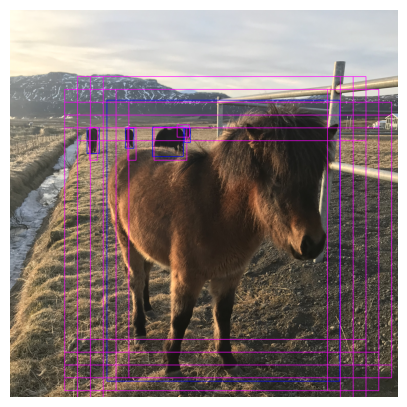

In [464]:
anchors_image = annotate_image(load_image(), bbox_annotations.astype(int))

matched_anchors = anchors[positive_anchors]
corners_anchors = convert_to_corners(matched_anchors).astype(int)

for i, (anchor, corner_anchor) in enumerate(zip(matched_anchors, corners_anchors)):
    x1,y1,x2,y2 = corner_anchor.astype(int)
    anchors_image = cv2.rectangle(anchors_image, (x1,y1), (x2,y2), color=(255, 0, 255), thickness=4)
draw_image(anchors_image)